In [7]:
# !pip install tf-nightly

ERROR: Could not find a version that satisfies the requirement tf-nightly (from versions: none)
ERROR: No matching distribution found for tf-nightly


In [60]:
import os
import pathlib

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import tensorflow as tf

from tensorflow.keras import layers
from tensorflow.keras import models
from IPython import display

# Set the seed value for experiment reproducibility.
seed = 42
tf.random.set_seed(seed)
np.random.seed(seed)

In [61]:
DATASET_PATH = 'test_1_home_recorded/test_split_sample_dataset'

data_dir = pathlib.Path(DATASET_PATH)
# if not data_dir.exists():
#   tf.keras.utils.get_file(
#       'mini_speech_commands.zip',
#       origin="http://storage.googleapis.com/download.tensorflow.org/data/mini_speech_commands.zip",
#       extract=True,
#       cache_dir='.', cache_subdir='data')

In [62]:
commands = np.array(tf.io.gfile.listdir(str(data_dir)))
commands = commands[commands != 'README.md']
print('Commands:', commands)

Commands: ['non_water' 'water']


In [63]:
train_ds, val_ds = tf.keras.utils.audio_dataset_from_directory(
    directory=data_dir,
    batch_size=64,
    validation_split=0.2,
    seed=0,
    output_sequence_length=8000,#16000,
    subset='both')

label_names = np.array(train_ds.class_names)
print()
print("label names:", label_names)

Found 384 files belonging to 2 classes.
Using 308 files for training.
Using 76 files for validation.

label names: ['non_water' 'water']


In [64]:
train_ds.element_spec

(TensorSpec(shape=(None, 8000, None), dtype=tf.float32, name=None),
 TensorSpec(shape=(None,), dtype=tf.int32, name=None))

In [65]:
def squeeze(audio, labels):
  audio = tf.squeeze(audio, axis=-1)
  return audio, labels

train_ds = train_ds.map(squeeze, tf.data.AUTOTUNE)
val_ds = val_ds.map(squeeze, tf.data.AUTOTUNE)

In [66]:
test_ds = val_ds.shard(num_shards=2, index=0)
val_ds = val_ds.shard(num_shards=2, index=1)

In [67]:
for example_audio, example_labels in train_ds.take(1):  
  print(example_audio.shape)
  print(example_labels.shape)

(64, 8000)
(64,)


In [68]:
label_names

array(['non_water', 'water'], dtype='<U9')

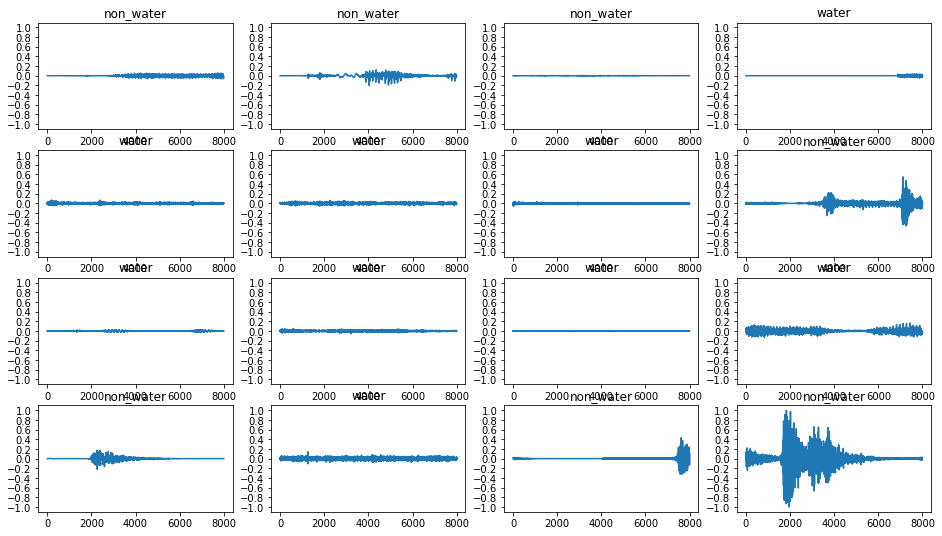

In [69]:
rows = 4
cols = 4
n = rows * cols
fig, axes = plt.subplots(rows, cols, figsize=(16, 9))

for i in range(n):
  if i>=n:
    break
  r = i // cols
  c = i % cols
  ax = axes[r][c]
  ax.plot(example_audio[i].numpy())
  ax.set_yticks(np.arange(-1.2, 1.2, 0.2))
  label = label_names[example_labels[i]]
  ax.set_title(label)
  ax.set_ylim([-1.1,1.1])

plt.show()

In [70]:
def get_spectrogram(waveform):
  # Convert the waveform to a spectrogram via a STFT.
  spectrogram = tf.signal.stft(
      waveform, frame_length=255, frame_step=128)
  # Obtain the magnitude of the STFT.
  spectrogram = tf.abs(spectrogram)
  # Add a `channels` dimension, so that the spectrogram can be used
  # as image-like input data with convolution layers (which expect
  # shape (`batch_size`, `height`, `width`, `channels`).
  spectrogram = spectrogram[..., tf.newaxis]
  return spectrogram

In [71]:
for i in range(10):
  label = label_names[example_labels[i]]
  waveform = example_audio[i]
  spectrogram = get_spectrogram(waveform)

  print('Label:', label)
  print('Waveform shape:', waveform.shape)
  print('Spectrogram shape:', spectrogram.shape)
  print('Audio playback')
  display.display(display.Audio(waveform, rate=16000))

Label: non_water
Waveform shape: (8000,)
Spectrogram shape: (61, 129, 1)
Audio playback


Label: non_water
Waveform shape: (8000,)
Spectrogram shape: (61, 129, 1)
Audio playback


Label: non_water
Waveform shape: (8000,)
Spectrogram shape: (61, 129, 1)
Audio playback


Label: water
Waveform shape: (8000,)
Spectrogram shape: (61, 129, 1)
Audio playback


Label: water
Waveform shape: (8000,)
Spectrogram shape: (61, 129, 1)
Audio playback


Label: water
Waveform shape: (8000,)
Spectrogram shape: (61, 129, 1)
Audio playback


Label: water
Waveform shape: (8000,)
Spectrogram shape: (61, 129, 1)
Audio playback


Label: non_water
Waveform shape: (8000,)
Spectrogram shape: (61, 129, 1)
Audio playback


Label: water
Waveform shape: (8000,)
Spectrogram shape: (61, 129, 1)
Audio playback


Label: water
Waveform shape: (8000,)
Spectrogram shape: (61, 129, 1)
Audio playback


In [72]:
def plot_spectrogram(spectrogram, ax):
  if len(spectrogram.shape) > 2:
    assert len(spectrogram.shape) == 3
    spectrogram = np.squeeze(spectrogram, axis=-1)
  # Convert the frequencies to log scale and transpose, so that the time is
  # represented on the x-axis (columns).
  # Add an epsilon to avoid taking a log of zero.
  log_spec = np.log(spectrogram.T + np.finfo(float).eps)
  height = log_spec.shape[0]
  width = log_spec.shape[1]
  X = np.linspace(0, np.size(spectrogram), num=width, dtype=int)
  Y = range(height)
  ax.pcolormesh(X, Y, log_spec)

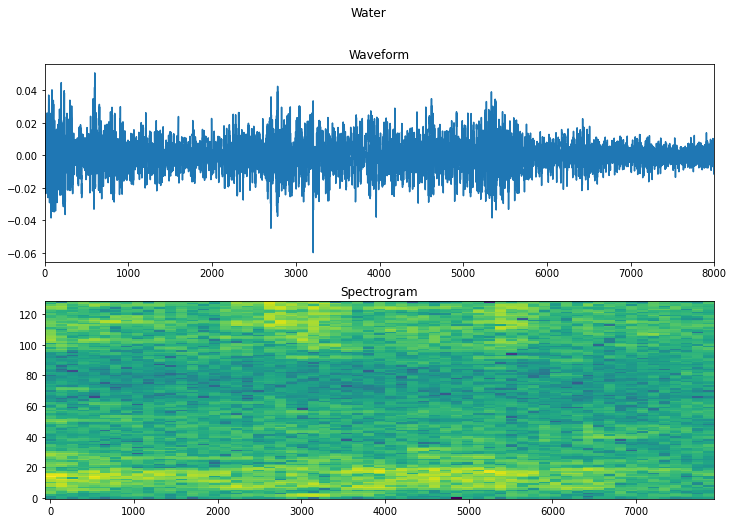

In [73]:
fig, axes = plt.subplots(2, figsize=(12, 8))
timescale = np.arange(waveform.shape[0])
axes[0].plot(timescale, waveform.numpy())
axes[0].set_title('Waveform')
axes[0].set_xlim([0, 8000])

plot_spectrogram(spectrogram.numpy(), axes[1])
axes[1].set_title('Spectrogram')
plt.suptitle(label.title())
plt.show()

In [74]:
def make_spec_ds(ds):
  return ds.map(
      map_func=lambda audio,label: (get_spectrogram(audio), label),
      num_parallel_calls=tf.data.AUTOTUNE)

In [75]:
train_spectrogram_ds = make_spec_ds(train_ds)
val_spectrogram_ds = make_spec_ds(val_ds)
test_spectrogram_ds = make_spec_ds(test_ds)

In [76]:
for example_spectrograms, example_spect_labels in train_spectrogram_ds.take(1):
  break

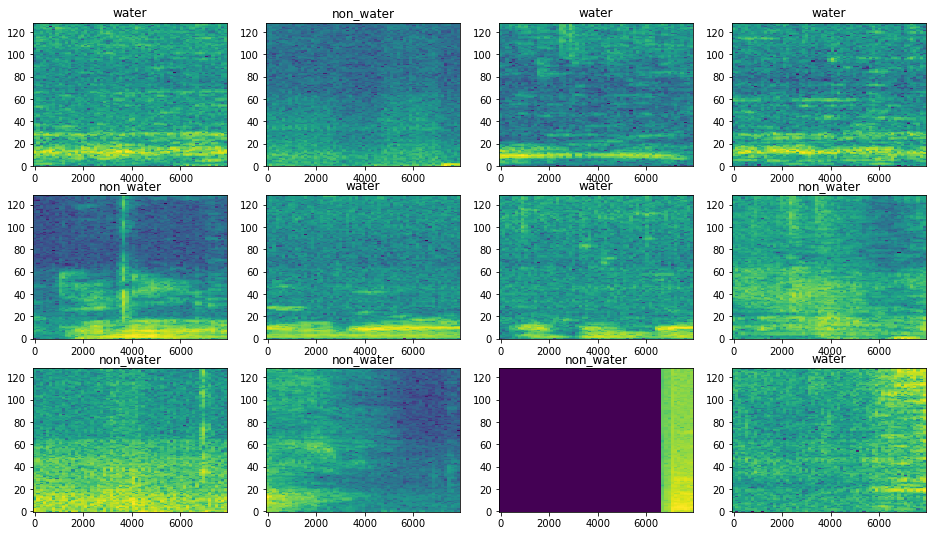

In [77]:
rows = 3
cols = 4
n = rows*cols
fig, axes = plt.subplots(rows, cols, figsize=(16, 9))

for i in range(n):
    r = i // cols
    c = i % cols
    ax = axes[r][c]
    plot_spectrogram(example_spectrograms[i].numpy(), ax)
    ax.set_title(commands[example_spect_labels[i].numpy()])

plt.show()

In [78]:
train_spectrogram_ds = train_spectrogram_ds.cache().shuffle(10000).prefetch(tf.data.AUTOTUNE)
val_spectrogram_ds = val_spectrogram_ds.cache().prefetch(tf.data.AUTOTUNE)
test_spectrogram_ds = test_spectrogram_ds.cache().prefetch(tf.data.AUTOTUNE)

In [79]:
input_shape = example_spectrograms.shape[1:]
print('Input shape:', input_shape)
num_labels = len(commands)

# Instantiate the `tf.keras.layers.Normalization` layer.
norm_layer = layers.Normalization()
# Fit the state of the layer to the spectrograms
# with `Normalization.adapt`.
norm_layer.adapt(data=train_spectrogram_ds.map(map_func=lambda spec, label: spec))

model = models.Sequential([
    layers.Input(shape=input_shape),
    # Downsample the input.
    layers.Resizing(32, 32),
    # Normalize.
    norm_layer,
    layers.Conv2D(32, 3, activation='relu'),
    layers.Conv2D(64, 3, activation='relu'),
    layers.MaxPooling2D(),
    layers.Dropout(0.25),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(num_labels),
])

model.summary()

Input shape: (61, 129, 1)
Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resizing_2 (Resizing)       (None, 32, 32, 1)         0         
                                                                 
 normalization_2 (Normalizat  (None, 32, 32, 1)        3         
 ion)                                                            
                                                                 
 conv2d_4 (Conv2D)           (None, 30, 30, 32)        320       
                                                                 
 conv2d_5 (Conv2D)           (None, 28, 28, 64)        18496     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 14, 14, 64)       0         
 2D)                                                             
                                                                 
 dropout_4 (Dropout)        

In [80]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy'],
)

In [81]:
EPOCHS = 10
history = model.fit(
    train_spectrogram_ds,
    validation_data=val_spectrogram_ds,
    epochs=EPOCHS,
    callbacks=tf.keras.callbacks.EarlyStopping(verbose=1, patience=2),
)

Epoch 1/10
5/5 [==============================] - 1s 214ms/step - loss: 0.5933 - accuracy: 0.6266 - val_loss: 0.5052 - val_accuracy: 0.7500
Epoch 2/10
5/5 [==============================] - 0s 102ms/step - loss: 0.3802 - accuracy: 0.8182 - val_loss: 0.3696 - val_accuracy: 0.8333
Epoch 3/10
5/5 [==============================] - 1s 112ms/step - loss: 0.2482 - accuracy: 0.8961 - val_loss: 0.2631 - val_accuracy: 0.9167
Epoch 4/10
5/5 [==============================] - 1s 118ms/step - loss: 0.1796 - accuracy: 0.9416 - val_loss: 0.1932 - val_accuracy: 0.9167
Epoch 5/10
5/5 [==============================] - 1s 116ms/step - loss: 0.1414 - accuracy: 0.9481 - val_loss: 0.1250 - val_accuracy: 1.0000
Epoch 6/10
5/5 [==============================] - 1s 116ms/step - loss: 0.0906 - accuracy: 0.9708 - val_loss: 0.0772 - val_accuracy: 1.0000
Epoch 7/10
5/5 [==============================] - 1s 105ms/step - loss: 0.0584 - accuracy: 0.9903 - val_loss: 0.0525 - val_accuracy: 1.0000
Epoch 8/10
5/5 [====

Text(0, 0.5, 'Accuracy [%]')

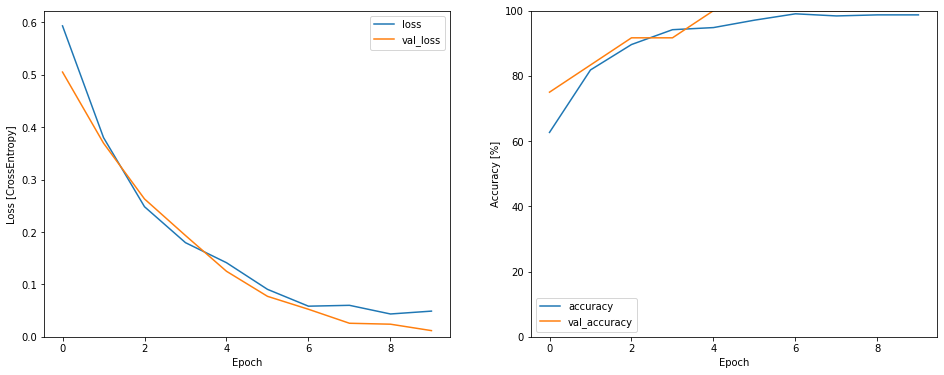

In [82]:
metrics = history.history
plt.figure(figsize=(16,6))
plt.subplot(1,2,1)
plt.plot(history.epoch, metrics['loss'], metrics['val_loss'])
plt.legend(['loss', 'val_loss'])
plt.ylim([0, max(plt.ylim())])
plt.xlabel('Epoch')
plt.ylabel('Loss [CrossEntropy]')

plt.subplot(1,2,2)
plt.plot(history.epoch, 100*np.array(metrics['accuracy']), 100*np.array(metrics['val_accuracy']))
plt.legend(['accuracy', 'val_accuracy'])
plt.ylim([0, 100])
plt.xlabel('Epoch')
plt.ylabel('Accuracy [%]')

In [83]:
model.evaluate(test_spectrogram_ds, return_dict=True)

1/1 [==============================] - 0s 163ms/step - loss: 0.0218 - accuracy: 1.0000


{'loss': 0.021766019985079765, 'accuracy': 1.0}

In [84]:
y_pred = model.predict(test_spectrogram_ds)

1/1 [==============================] - 0s 101ms/step


In [85]:
y_pred = tf.argmax(y_pred, axis=1)

In [86]:
y_true = tf.concat(list(test_spectrogram_ds.map(lambda s,lab: lab)), axis=0)

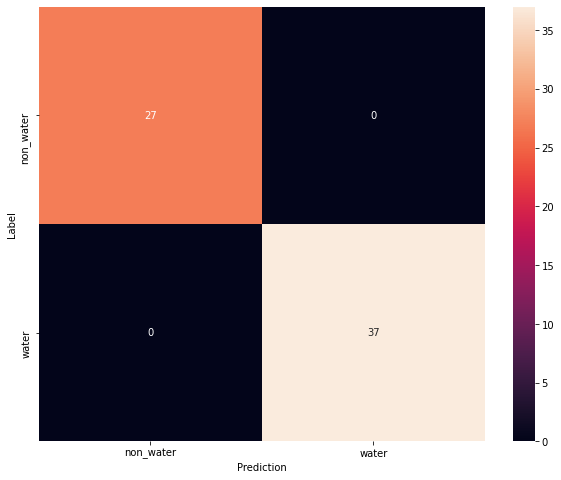

In [87]:
confusion_mtx = tf.math.confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(confusion_mtx,
            xticklabels=commands,
            yticklabels=commands,
            annot=True, fmt='g')
plt.xlabel('Prediction')
plt.ylabel('Label')
plt.show()

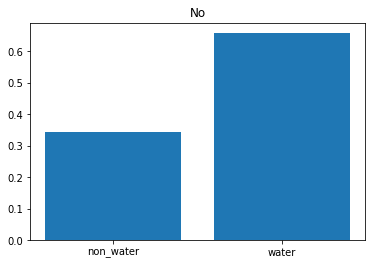

In [90]:
# x = data_dir/'non_water/preprocessed_non water sound sample_0.0_0.5 - Copy - Copy.wav'
x = data_dir/'water/preprocessed_water sound sample_0.0_0.5 - Copy - Copy.wav'
# x = data_dir/'down/00b01445_nohash_1.wav'
x = tf.io.read_file(str(x))
x, sample_rate = tf.audio.decode_wav(x, desired_channels=1, desired_samples=8000,)
x = tf.squeeze(x, axis=-1)
waveform = x
x = get_spectrogram(x)
x = x[tf.newaxis,...]

prediction = model(x)
plt.bar(commands, tf.nn.softmax(prediction[0]))
plt.title('No')
plt.show()

display.display(display.Audio(waveform, rate=16000))

In [91]:
tf.nn.softmax(prediction[0])

<tf.Tensor: shape=(2,), dtype=float32, numpy=array([0.34279367, 0.65720636], dtype=float32)>

In [92]:
(commands, prediction[0])

(array(['non_water', 'water'], dtype='<U9'),
 <tf.Tensor: shape=(2,), dtype=float32, numpy=array([-0.65808445, -0.00721516], dtype=float32)>)

In [97]:
class ExportModel(tf.Module):
  def __init__(self, model):
    self.model = model

    # Accept either a string-filename or a batch of waveforms.
    # YOu could add additional signatures for a single wave, or a ragged-batch. 
    self.__call__.get_concrete_function(
        x=tf.TensorSpec(shape=(), dtype=tf.string))
    self.__call__.get_concrete_function(
       x=tf.TensorSpec(shape=[None, 8000], dtype=tf.float32))


  @tf.function
  def __call__(self, x):
    # If they pass a string, load the file and decode it. 
    if x.dtype == tf.string:
      x = tf.io.read_file(x)
      x, _ = tf.audio.decode_wav(x, desired_channels=1, desired_samples=8000,)
      x = tf.squeeze(x, axis=-1)
      x = x[tf.newaxis, :]

    x = get_spectrogram(x)  
    result = self.model(x, training=False)

    class_ids = tf.argmax(result, axis=-1)
    class_names = tf.gather(label_names, class_ids)
    return {'predictions':result,
            'class_ids': class_ids,
            'class_names': class_names}

In [98]:
export = ExportModel(model)
export(tf.constant(str(data_dir/'water/preprocessed_water sound sample_0.0_0.5 - Copy - Copy.wav')))

{'predictions': <tf.Tensor: shape=(1, 2), dtype=float32, numpy=array([[-0.65808445, -0.00721516]], dtype=float32)>,
 'class_ids': <tf.Tensor: shape=(1,), dtype=int64, numpy=array([1], dtype=int64)>,
 'class_names': <tf.Tensor: shape=(1,), dtype=string, numpy=array([b'water'], dtype=object)>}

In [100]:
tf.saved_model.save(export, "saved_water")
imported = tf.saved_model.load("saved_water")
imported(tf.constant(str(data_dir/'water/preprocessed_water sound sample_0.0_0.5 - Copy - Copy.wav')))

INFO:tensorflow:Assets written to: saved_water\assets


INFO:tensorflow:Assets written to: saved_water\assets


{'class_ids': <tf.Tensor: shape=(1,), dtype=int64, numpy=array([1], dtype=int64)>,
 'predictions': <tf.Tensor: shape=(1, 2), dtype=float32, numpy=array([[-0.65808445, -0.00721516]], dtype=float32)>,
 'class_names': <tf.Tensor: shape=(1,), dtype=string, numpy=array([b'water'], dtype=object)>}

### now the model is done, and now we would predict each of files

In [123]:
#let's try to do it in 1 dataset

TEST_DATASET_PATH = 'test_1_home_recorded/test_split_test_dataset'

test_data_dir = pathlib.Path(TEST_DATASET_PATH)

prediction = imported(tf.constant(str(test_data_dir/'preprocessed_test data water and non_water_0.wav')))
result = tf.get_static_value(prediction['class_names'])[0].decode("utf-8") 
result

'non_water'

In [138]:
#get all data and check the result one by one
# get all non-wav audio file in the folder

import os
import pathlib

# AUDIO_FILE_PATH = 'test_pydub'
TEST_DATASET_PATH = 'test_1_home_recorded/test_split_test_dataset'

prediction_dict = {'split':[], 'water': []}

audio_file_dir = pathlib.Path(TEST_DATASET_PATH)
dir_list = os.listdir(audio_file_dir)

for audio_file in dir_list:
    prediction = imported(tf.constant(str(test_data_dir/audio_file)))
    prediction_dict['split'].append(audio_file[:-4]) # remove ".wav"
    prediction_dict['water'].append(1 if tf.get_static_value(prediction['class_names'])[0].decode("utf-8")=="water" else 0) 


In [139]:
prediction_dict

{'split': ['preprocessed_test data water and non_water_0',
  'preprocessed_test data water and non_water_1',
  'preprocessed_test data water and non_water_10',
  'preprocessed_test data water and non_water_11',
  'preprocessed_test data water and non_water_12',
  'preprocessed_test data water and non_water_13',
  'preprocessed_test data water and non_water_14',
  'preprocessed_test data water and non_water_15',
  'preprocessed_test data water and non_water_16',
  'preprocessed_test data water and non_water_17',
  'preprocessed_test data water and non_water_18',
  'preprocessed_test data water and non_water_19',
  'preprocessed_test data water and non_water_2',
  'preprocessed_test data water and non_water_20',
  'preprocessed_test data water and non_water_21',
  'preprocessed_test data water and non_water_22',
  'preprocessed_test data water and non_water_23',
  'preprocessed_test data water and non_water_24',
  'preprocessed_test data water and non_water_25',
  'preprocessed_test data

In [140]:
import pandas as pd

prediction_dataset_df = pd.DataFrame.from_dict(prediction_dict)
prediction_dataset_df

,split,water
0,preprocessed_test data water and non_water_0,0
1,preprocessed_test data water and non_water_1,0
2,preprocessed_test data water and non_water_10,1
3,preprocessed_test data water and non_water_11,0
4,preprocessed_test data water and non_water_12,0
...,...,...
67,preprocessed_test data water and non_water_7,1
68,preprocessed_test data water and non_water_70,0
69,preprocessed_test data water and non_water_71,0
70,preprocessed_test data water and non_water_8,1


In [141]:
prediction_dataset_df.to_csv("prediction_result.csv")